In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from utils._statistical_relevance import _get_conv_response
from utils._resnet import resnet18_8

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('physrev_noticks.mplstyle')
plt.rcParams.update({"figure.figsize": [3.25, 1.01]})
plt.rcParams['figure.dpi'] = "300"

In [37]:
model_path = f"./model_backups/resnet18_8_b64_lr0.0001_1000_noiseless/checkpoint.pt"
model = resnet18_8()
model.load_state_dict(torch.load(model_path), strict=False)
model.eval()

def _get_conv_response(model):
    model.eval()

    torch.zeros(1, 2, 1, 1000)
    feature_map_results = []
    model = resnet18_8()
    activation = {}

    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()

        return hook

    input = torch.zeros(1, 2, 1, 1000)
    with torch.no_grad():
        model.layer4.register_forward_hook(get_activation('l4'))
        output = model(input)
        baseline = activation['l4'].squeeze()

    input = torch.zeros(1, 2, 1, 1000)
    feature_map_results = []

    for i in range(1000):
        activation = {}

        def get_activation(name):
            def hook(model, input, output):
                activation[name] = output.detach()

            return hook

        input = torch.zeros(1, 2, 1, 1000)
        input[0][0][0][i] = 1
        input[0][1][0][i] = 1
        with torch.no_grad():
            model.layer4.register_forward_hook(get_activation('l4'))
            output = model(input)
            feature_map_results.append((activation['l4'].squeeze() - baseline).mean(0))

    responds = [[res[i] for res in feature_map_results] for i in range(32)]

    return responds

In [38]:
responds = _get_conv_response(model)

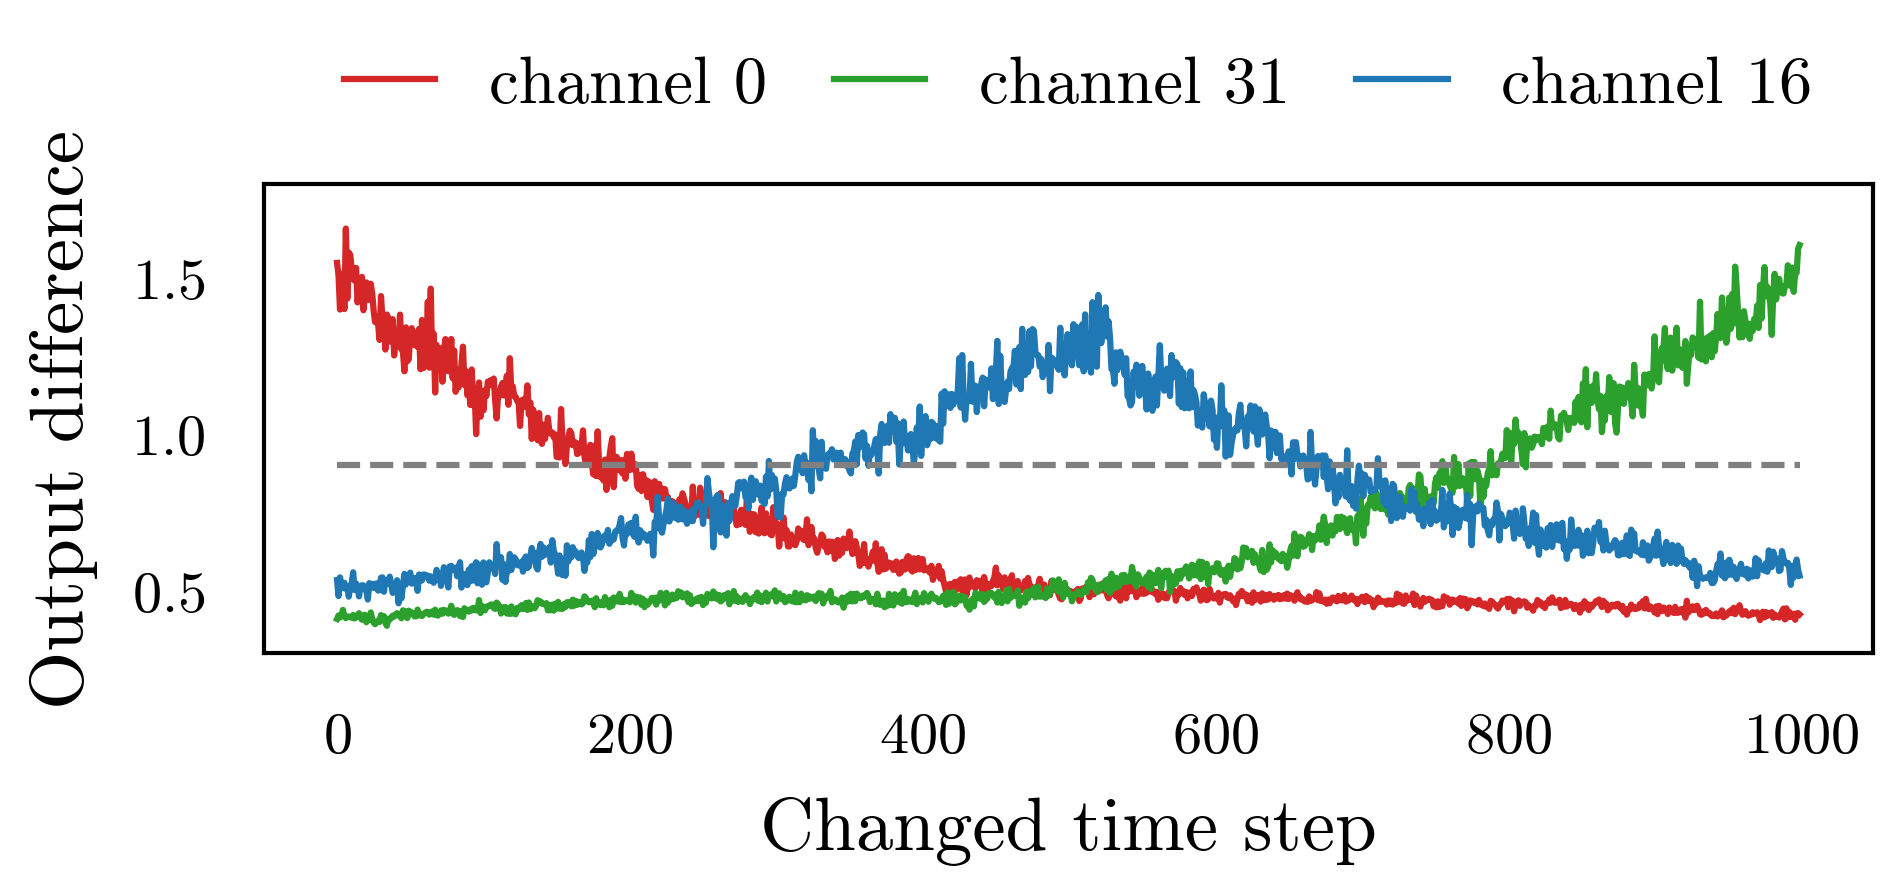

In [65]:
plt.plot(responds[0], label="channel 0", c="tab:red")
plt.plot(responds[-1], label="channel 31", c="tab:green")
plt.plot(responds[16], label="channel 16", c="tab:blue")
plt.hlines(0.9, xmin=0, xmax=1000-1, ls="--",
           color="gray")
plt.ylim(0.3, 1.8)
plt.legend(loc="best", ncol=3, bbox_to_anchor=(1, 1.4))
plt.xlabel("Changed time step")
plt.ylabel("Output difference")
plt.savefig("./figures/layer_response.pdf")
plt.show()